In [4]:
import jax.numpy as jnp
import jax
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)
jax.config.update("jax_platform_name", "cpu")
x = jnp.arange(5.0)
print(selu(x))
# This code defines a function called selu, which implements the Scaled Exponential Linear Unit (SELU) activation function. SELU is an activation function commonly used in neural networks, particularly for deep networks, as it helps maintain a self-normalizing property during training.
# Parameters:

# x: The input array, typically a tensor of activations from the previous layer.
# alpha: A constant parameter for the negative values (default is 1.67).
# lmbda: A scaling constant for the entire output (default is 1.05).
# Function Explanation:

# jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha): This expression applies different operations based on whether each element in x is positive or negative.
# For positive values of x, the function returns x.
# For negative values of x, it applies the expression alpha * jnp.exp(x) - alpha, which creates an exponential curve for negative inputs.
# Finally, the result is multiplied by lmbda, scaling the entire output.
# Purpose of SELU:

# SELU is designed to help maintain self-normalization in neural networks, meaning it helps keep the output of each layer within a specific range. This reduces the need for batch normalization, particularly in deep networks.
# The function combines both linear and exponential elements, making it nonlinear and thus suitable for introducing nonlinearity in neural networks.

[0.        1.05      2.1       3.1499999 4.2      ]


In [5]:
from jax import random

key = random.key(1701)
x = random.normal(key, (1_000_000,))
%timeit selu(x).block_until_ready()

5.2 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
from jax import jit

selu_jit = jit(selu)
_ = selu_jit(x)  # compiles on first call
%timeit selu_jit(x).block_until_ready()

2.22 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
from jax import grad

def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))
 
x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))
# The function sum_logistic applies the logistic function element-wise on x and then sums the results.
# Mathematically, if x = [x1, x2, x3], then:


[0.25       0.19661197 0.10499357]


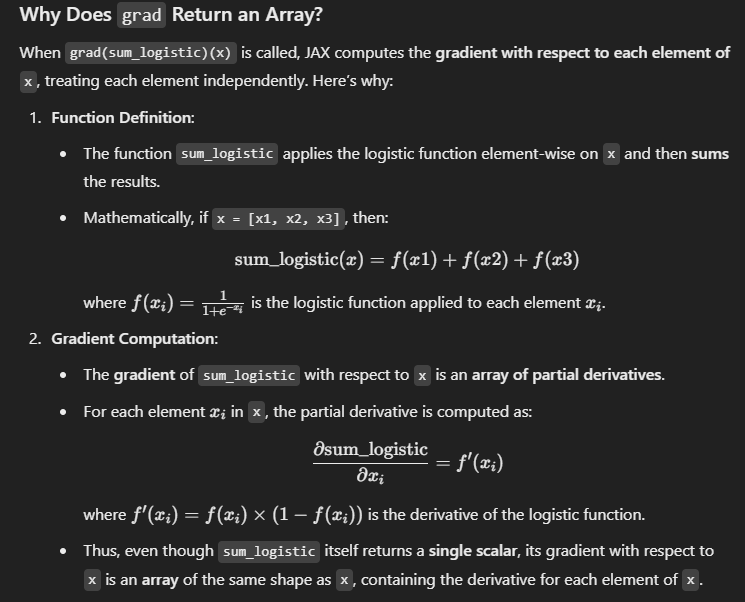

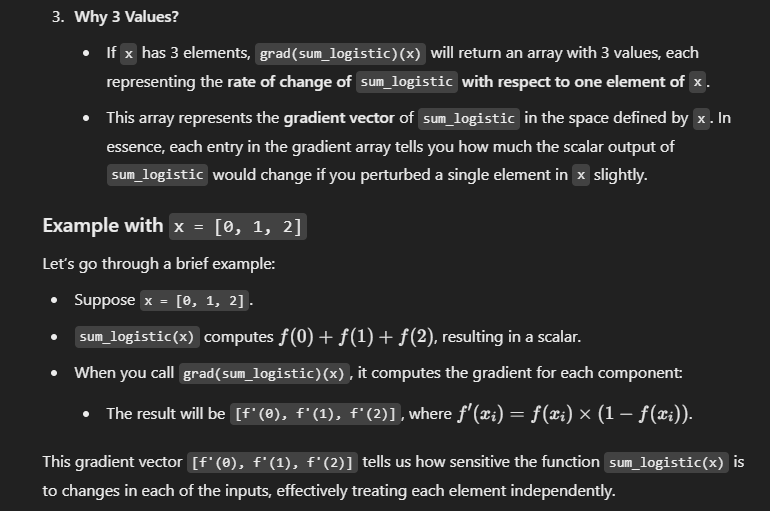

In [8]:
def first_finite_differences(f, x, eps=1E-3):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


In [10]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


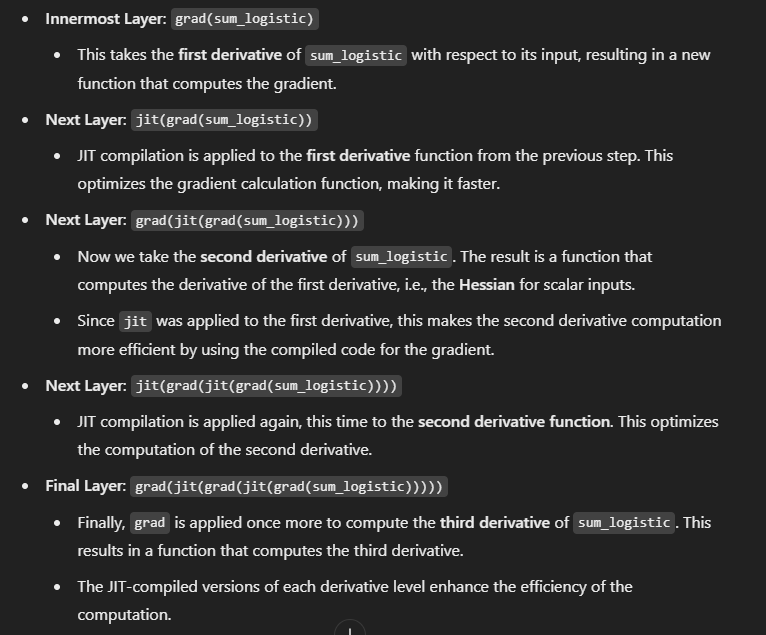

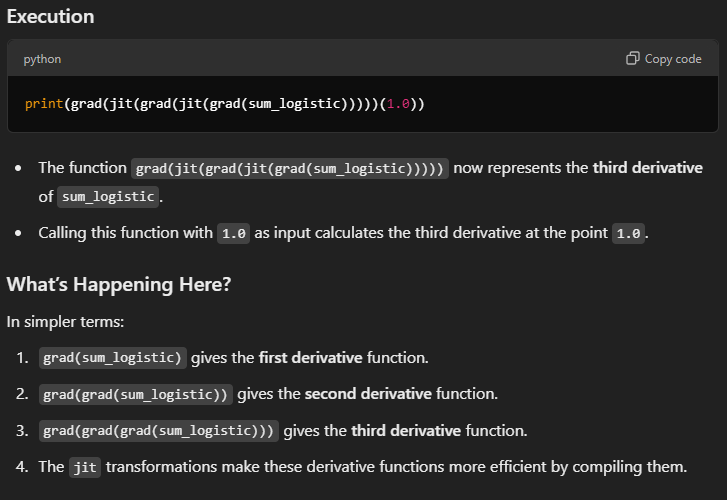

In [11]:
from jax import jacobian
print(jacobian(jnp.exp)(x_small))

[[1.        0.        0.       ]
 [0.        2.7182817 0.       ]
 [0.        0.        7.389056 ]]


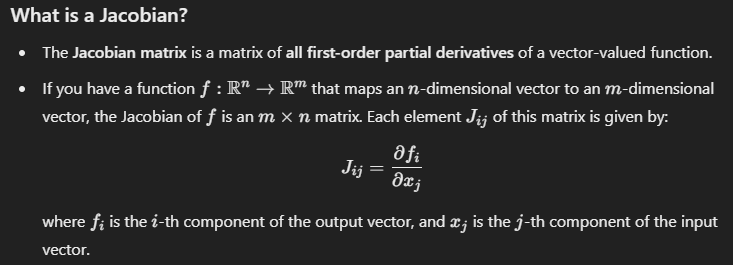

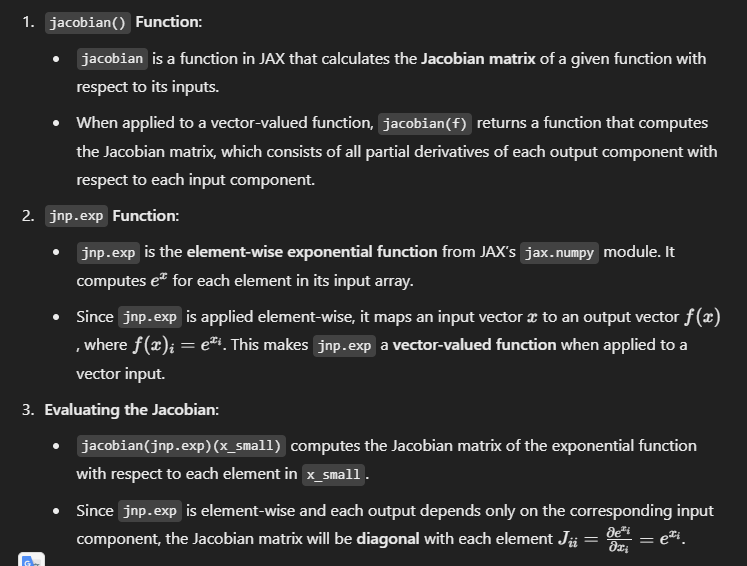

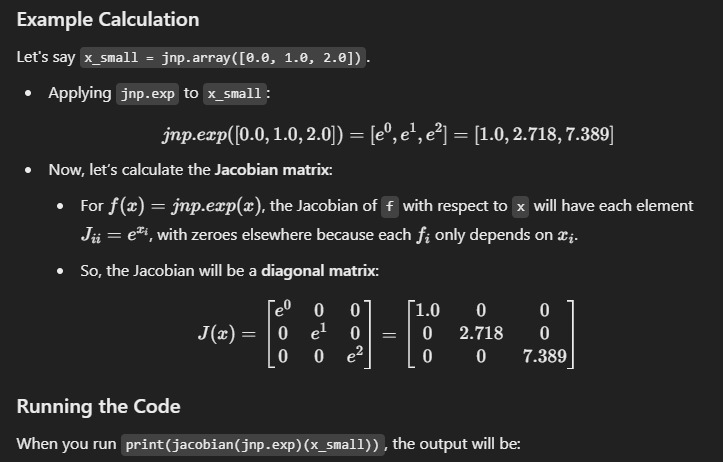

In [12]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))
print(hessian(sum_logistic)(x_small))

[[-0.         -0.         -0.        ]
 [-0.         -0.09085776 -0.        ]
 [-0.         -0.         -0.07996249]]


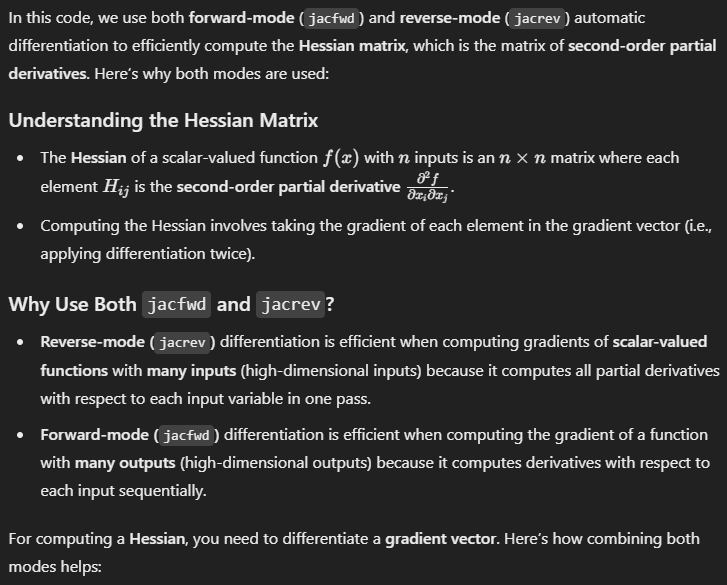

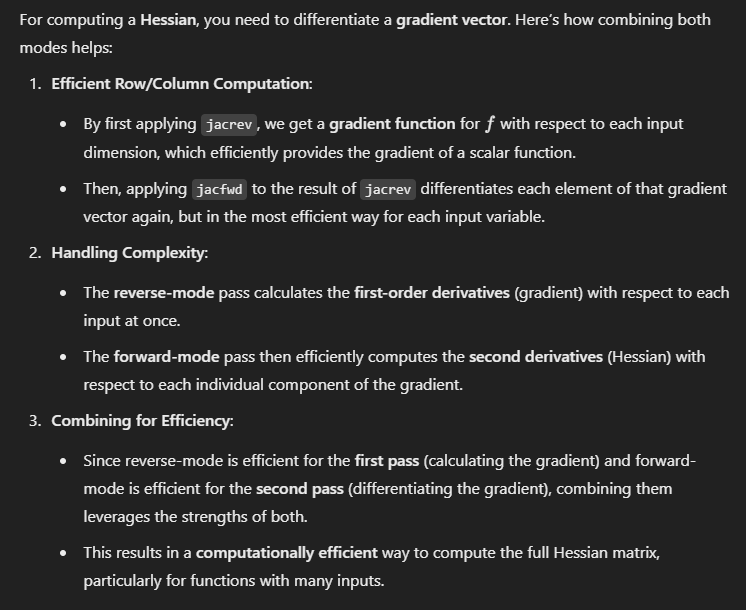

Auto-vectorization with jax.vmap()

Another useful transformation is vmap(), the vectorizing map. It has the familiar semantics of mapping a function along array axes, but instead of explicitly looping over function calls, it transforms the function into a natively vectorized version for better performance. When composed with jit(), it can be just as performant as manually rewriting your function to operate over an extra batch dimension.

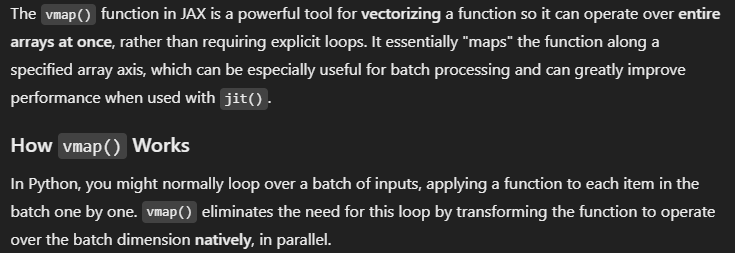

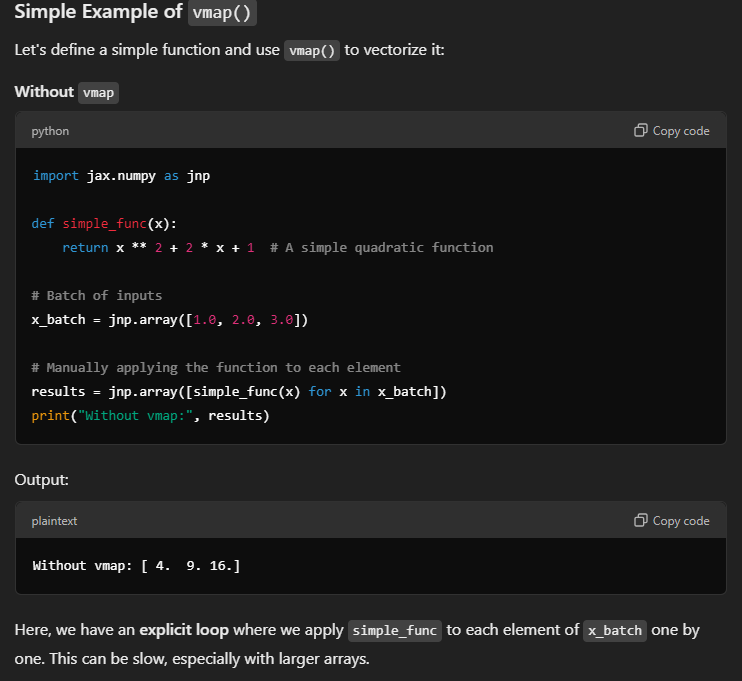

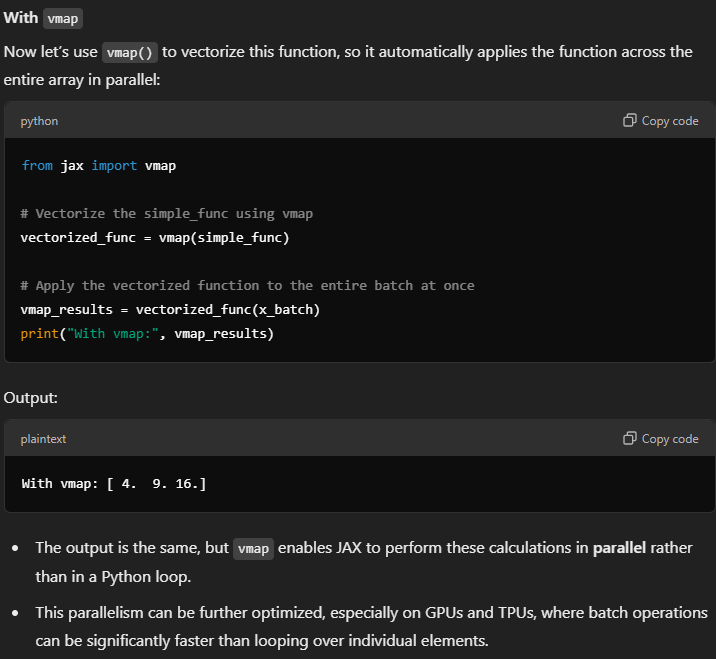

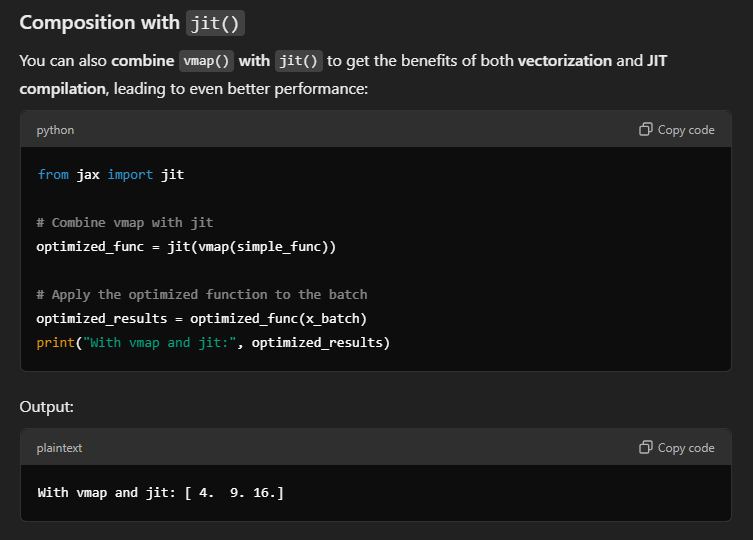

In [13]:
key1, key2 = random.split(key)

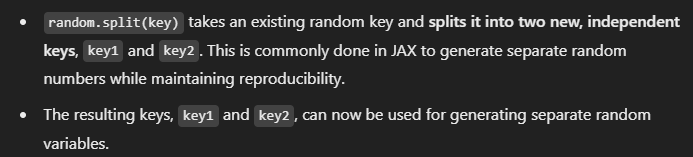

In [14]:
key1

Array((), dtype=key<fry>) overlaying:
[  56197195 1801093307]

In [15]:
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

def apply_matrix(x):
  return jnp.dot(mat, x)

In [16]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
885 µs ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
import numpy as np

@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, mat.T)#explicitely managing the matrix sizes

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
15.4 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


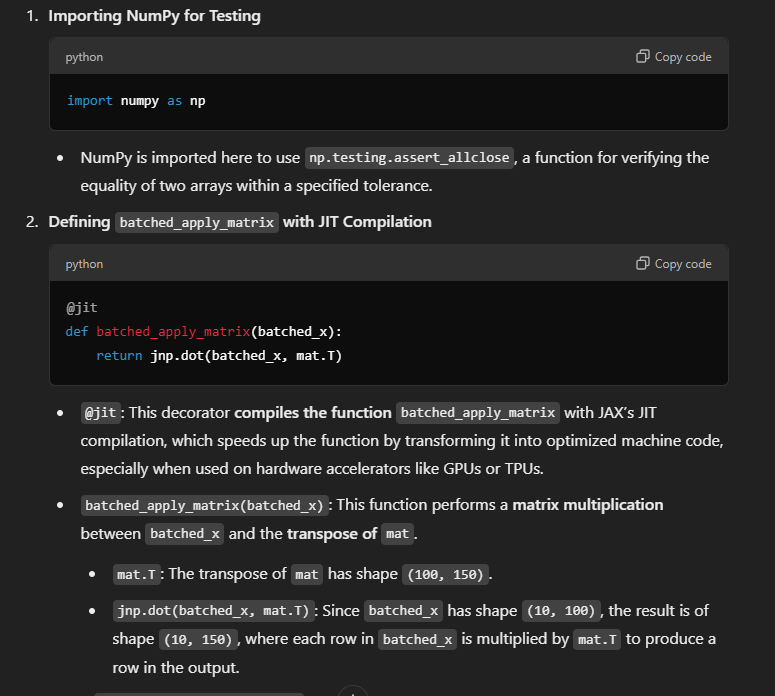

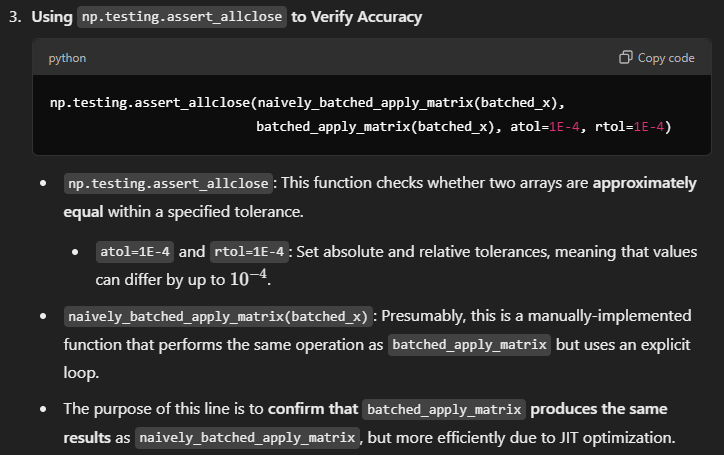

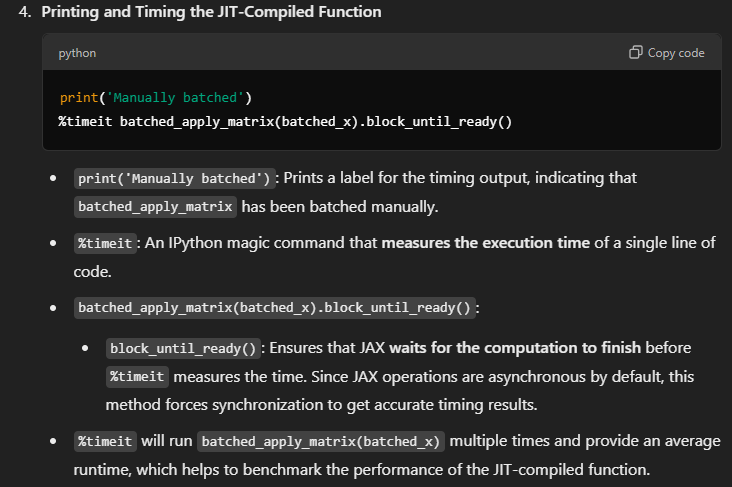

In [18]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
21.8 µs ± 825 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


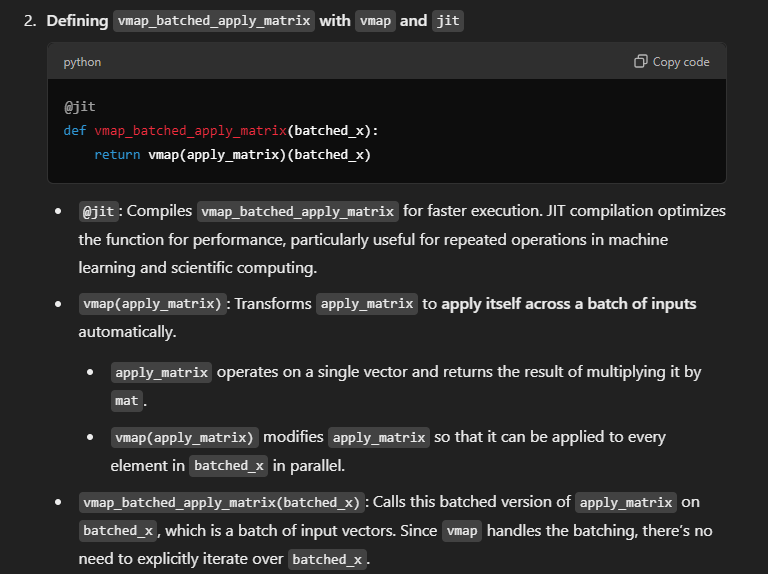